In [17]:
from fastai2.text.all import *

## Create databunch form LM

In [18]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [19]:
len(EN_TEXT)

1039052

In [20]:
toks = tokenize1(EN_TEXT)

In [21]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [22]:
vocab = make_vocab(Counter(toks), max_vocab=2000)

len(vocab)

2008

In [23]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [24]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [25]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

In [26]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [27]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

## Train LM

In [28]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    AWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

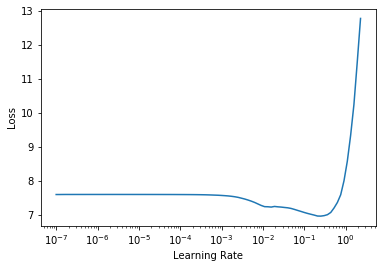

In [29]:
learn.lr_find()

In [30]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.462642,5.171839,0.125846,176.238602,00:11
1,5.065055,4.794683,0.176020,120.866119,00:11
2,4.808814,4.564898,0.199479,96.052750,00:11
3,4.646318,4.412355,0.217860,82.463432,00:11
4,4.481042,4.304848,0.232509,74.057938,00:11


In [31]:
learn.save('5epochs')

## Calculate loss given embeddings

In [32]:
learn = learn.load('5epochs')

In [33]:
def loss():
    preds, targs = learn.get_preds()
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [34]:
loss()

(7.520119667053223, 0.2332715392112732)

In [35]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0])
            targs.append(b[1])

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [36]:
loss()

(4.302262783050537, 0.23329360783100128)

Sylvain fixed the earlier issue I reported but now this doesn't look like. Opening another issue [issue](https://github.com/fastai/fastai2/issues/38).

In [37]:
learn.model[0].encoder.weight[:15].zero_();

In [38]:
loss()

(5.863871097564697, 0.07247528433799744)

In [39]:
learn = learn.load('5epochs')

In [40]:
loss()

(4.303104400634766, 0.23338188230991364)

## Permute embeddings

In [41]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        self.p = nn.Parameter( torch.eye(self.num_embeddings) )
        self.p.requires_grad = False
        
        self.reset_parameters()
        
    def forward(self, words):
        return F.embedding(words, self.p @ self.weight)
    
    def reset_parameters(self):
        pass
#         self.weight.data.normal_(0,1)
#         self.p.data = torch.eye(self.num_embeddings)
    

In [42]:
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.encoder_dp = self.encoder # chosing to train without embedding dropout (to reduce code complexity + not sure it makes a lot of sense for what we want to do anyhow) 
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [43]:
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [44]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

In [45]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.445153,5.144691,0.134071,171.518387,00:11
1,5.046057,4.783726,0.175195,119.548927,00:11
2,4.754889,4.549178,0.202734,94.554665,00:11
3,4.573718,4.401268,0.220464,81.554214,00:11
4,4.483709,4.286499,0.232856,72.711464,00:11
5,4.371283,4.209051,0.241319,67.292656,00:11
6,4.282155,4.150193,0.244054,63.446228,00:11
7,4.194405,4.109488,0.248459,60.915550,00:11
8,4.079652,4.062927,0.253689,58.144238,00:11
9,4.010215,4.039865,0.254731,56.818645,00:11


In [46]:
learn.save('pLSTM_10epochs')

In [47]:
learn.load('pLSTM_10epochs')

In [48]:
learn.predict('peter was', n_words=3, temperature=0.5)

'peter was not to be'

In [49]:
@patch_to(LMLearner)
@delegates(tokenize1)
def next_word_candidates(self, text, **kwargs):
    self.model.reset()
    tokens = tokenize1(text, **kwargs)
    tfm = self.dbunch.train_ds.numericalize
    idxs = tfm(tokens).to(self.dbunch.device)
    preds,_ = self.get_preds(dl=[(idxs[None],)])
    res = preds[0][-1]
    tokens = [tfm.vocab[i] for i in res.argsort(descending=True)]
    return tokens

In [50]:
learn.next_word_candidates('pete was')[:10]

['a', 'xxunk', 'the', 'his', 'not', 'to', 'no', 'in', 'an', 'as']

In [51]:
import warnings

In [52]:
@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    learn.model[0].encoder.p.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    learn.model[0].encoder.p.requires_grad = False

In [53]:
learn.optimize_permutation()

In [54]:
learn.model[0].encoder.p.requires_grad

True

In [55]:
def aza_loss(input=None, target=None, scaling_factor=5/2000, debug=False):
    p = learn.model[0].encoder.p
    sums_to_one = (1-p.abs().sum(dim=0)).abs().sum() + (1-p.abs().sum(dim=1)).abs().sum()
#     extremize = (1-p.max(dim=0)[0]).abs().sum() + (1-p.max(dim=1)[0]).abs().sum() # + (p.min(dim=0)[0]).abs().max()#(10*(1-p.max()).abs()) + (10*p.min()).abs()
    the_model = CrossEntropyLossFlat()(input, target)
    if debug: return sums_to_one, the_model
    else:     return scaling_factor * sums_to_one + (1 - scaling_factor) * the_model

In [56]:
learn.loss_func = aza_loss

In [57]:
learn.model[0].encoder.p

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', requires_grad=True)

In [58]:
preds, targs = learn.get_preds()

In [59]:
aza_loss(preds, targs, debug=True)

(tensor(0., device='cuda:0', grad_fn=<AddBackward0>), tensor(4.0364))

In [60]:
nn.init.kaiming_normal_(learn.model[0].encoder.p)

Parameter containing:
tensor([[ 0.0737, -0.0738, -0.0139,  ...,  0.0113,  0.0038,  0.0149],
        [ 0.0267,  0.0483,  0.0067,  ...,  0.0296, -0.0558, -0.0541],
        [-0.0134, -0.0023, -0.0278,  ..., -0.0134,  0.0255, -0.0130],
        ...,
        [-0.0150,  0.0249,  0.0094,  ...,  0.0162, -0.0224,  0.0570],
        [-0.0005,  0.0215,  0.0034,  ..., -0.0275,  0.0227,  0.0385],
        [-0.0341,  0.0235,  0.0297,  ..., -0.0399, -0.0103, -0.0079]],
       device='cuda:0', requires_grad=True)

In [61]:
loss()

(6.341344356536865, 0.05755649879574776)

In [62]:
aza_loss(preds, targs)

tensor(501.3347, device='cuda:0', grad_fn=<AddBackward0>)

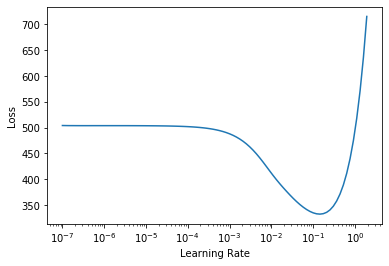

In [63]:
learn.lr_find()

In [64]:
learn.fit(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,172.867615,127.810493,0.183832,inf,00:10
1,26.892252,15.838667,0.205295,7562156.000000,00:10
2,5.200924,4.885458,0.209440,132.351135,00:10
3,4.583782,4.591830,0.224067,98.674820,00:10
4,4.463310,4.476338,0.226541,87.912186,00:10
5,4.412530,4.446977,0.231337,85.368500,00:10
6,4.340814,4.415351,0.234375,82.710899,00:10
7,4.315864,4.403653,0.235807,81.748962,00:10
8,4.301634,4.378039,0.238346,79.681618,00:10
9,4.296843,4.381155,0.238802,79.930298,00:10


In [65]:
learn.save('pLSTM_15epochs_permute_embeddings')

In [66]:
def hitInTopN(n=1, how_many=None, prints=True):
    data = learn.model[0].encoder.p.data.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [67]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.8100000023841858, 0.9899999499320984)

In [68]:
acc1 = [(x, hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, hitInTopN(10, x)) for x in range(50,1500,200)]

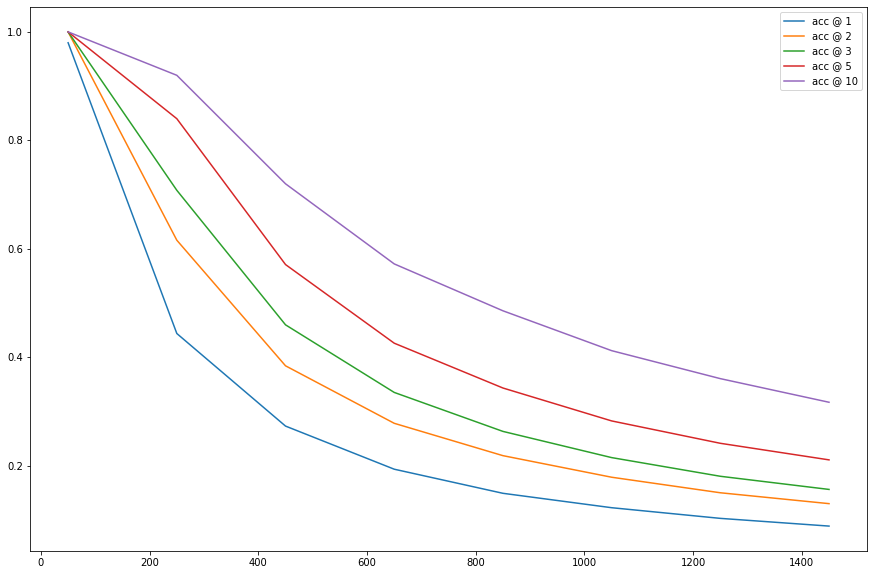

In [69]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [70]:
data = learn.model[0].encoder.p.data.argsort(descending=True)[:, :5]
print('actual word\t\tpredictions\n')
for i in range(60, 80):
    print(f'{learn.dbunch.vocab[i]}\t\t{[learn.dbunch.vocab[idx] for idx in data[i]]}')

actual word		predictions

would		['must', 'should', 'would', 'might', 'did']
then		['then', 'presently', 'however', 'and', 'but']
we		['we', 'they', 'i', 'he', 'you']
my		['my', 'your', 'coburg', 'no', 'the']
what		['what', 'why', 'if', 'when', 'that']
up		['up', 'out', 'down', 'across', 'away']
from		['of', 'toward', 'upon', 'from', 'around']
which		['which', 'they', 'who', 'unless', 'he']
out		['out', 'up', 'down', 'gutenberg', 'on']
me		['me', 'us', 'him', "n't", 'you']
one		['one', 'aunt', 'electronic', 'two', 'this']
if		['if', ':', 'wo', 'when', 'let']
now		['now', 'understand', 'however', 'then', 'well']
when		['because', 'what', 'when', ':', 'if']
them		['them', 'him', 'himself', 'us', 'her']
or		['and', 'or', 'chapter', '[', 'of']
could		['could', 'would', 'can', 'might', 'must']
been		['been', "'re", 'be', 'have', 'were']
are		['are', 'is', 'was', 'am', 'were']
an		['an', 'a', 'the', 'archive', 'upper']


## Other related architectures

In [ ]:
# mixer

class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) ) # these are embeddings!
        
        self.p_matrix_as_embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.p_matrix_as_embeddings.weight = nn.Parameter(torch.eye(self.num_embeddings))
        self.p_matrix_as_embeddings.weight.requires_grad = False
        
    def forward(self, words):
        return self.p_matrix_as_embeddings(words) @ self.weight
    
    def reset_parameters(self): pass

In [ ]:
# mixer with softmax

class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) ) # these are embeddings!
        
        self.p_matrix_as_embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.p_matrix_as_embeddings.weight = nn.Parameter(torch.eye(self.num_embeddings) * 45 - 0.0075)
        self.p_matrix_as_embeddings.weight.requires_grad = False
        
    def forward(self, words):
        return self.p_matrix_as_embeddings(words).softmax(-1) @ self.weight
    
    def reset_parameters(self): pass

Mixer showed comparable performance to the initial arch (with a slight edge going to the initial arch). Mixer with softmax significantly emphasized top1 performance. Top1 accuracy was slightly better but its performance on subsequent guesses was abysmal.